# To what extend are census tracts over- or under-represented in Craigslist rental listings?

For each city, get all rental listings and get count per tract. For each tract that has at least one listing, get census variables (2014 ACS DP) including number of renter-occupied units. Calculate each tract's share of total renter-occupied units. Then allocate the number of listings proportionally according to that share. Then compare how proportional allocation compares to Craigslist allocation.

In [1]:
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import Point

census_data_path = 'data/downloaded_census_data.geojson'
craigslist_path = 'data/listings_joined_tracts.csv'
cities_path = 'data/study_sites.csv'
output_path = 'data/features.csv'

## Load census tracts data

These are all the tracts within our study sites (cities), and they have ACS variables loaded.

In [2]:
tracts = gpd.read_file(census_data_path).rename(columns={'index':'GEOID'}).set_index('GEOID')
assert tracts.index.is_unique
print(len(tracts))
tracts.head(3)

12505


,ALAND,place_geoid,place_name,DP05_0001E,DP05_0017E,DP05_0008PE,DP05_0009PE,DP05_0066PE,DP05_0072PE,DP05_0033PE,...,DP02_0022PE,DP02_0079PE,DP02_0067PE,DP02_0111PE,DP02_0092PE,state,county,DP05_0072PE_2012,DP05_0072PE_2015,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,4.3,16.5,4.6,17.1,78.5,...,3.8,84.7,9.0,94.2,3.1,01,073,15.5,16.9,"POLYGON ((-86.74404800000001 33.573646, -86.74..."
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,7.9,17.2,18.0,4.6,67.2,...,3.6,85.9,14.3,77.7,16.5,01,073,7.6,5.4,"POLYGON ((-86.76195 33.540608, -86.761394 33.5..."
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,7.0,18.1,0.7,7.9,90.8,...,7.3,78.4,3.3,98.2,0.5,01,073,6.9,9.4,"POLYGON ((-86.78617300000001 33.5658, -86.7857..."


## Load listings data

These are cleaned rental listings and they have tracts fips code attached.

In [3]:
%%time
dtypes = {'tract_geoid' : str}
listings = pd.read_csv(craigslist_path, dtype=dtypes)
print(len(listings))

1392866
Wall time: 1.54 s


In [4]:
listings.head()

,date,region,bedrooms,rent,sqft,tract_geoid,lat,lng
0,2014-05-11,santabarbara,3.0,3500.0,1200.0,06083001304,34.399757,-119.726987
1,2014-05-11,santabarbara,2.0,850.0,882.0,06083002924,34.411019,-119.855845
2,2014-05-11,santabarbara,1.0,1290.0,NaN,06083002924,34.410415,-119.854330
3,2014-05-11,santabarbara,1.0,1660.0,NaN,06083000102,34.441460,-119.754324
4,2014-05-11,santabarbara,2.0,3200.0,NaN,06083002924,34.410416,-119.854530


In [5]:
# drop duplicates based on these attributes
listings = listings.drop_duplicates(subset=['rent', 'sqft', 'bedrooms', 'neighborhood'])
len(listings)

392179

In [6]:
# retain only those listings in the census tracts we're interested in, then convert to a geodataframe
mask = listings['tract_geoid'].isin(tracts.index)
listings_in_tracts = gpd.GeoDataFrame(listings[mask])
listings_in_tracts['geometry'] = listings_in_tracts.apply(lambda row: Point((row['lng'], row['lat'])), axis=1)
len(listings_in_tracts)

119005

In [7]:
# add city (place_geoid) to each listing
listings_in_tracts = pd.merge(left=listings_in_tracts, right=tracts[['place_geoid']], 
                              how='inner', left_on='tract_geoid', right_index=True)

In [8]:
# how many tracts are within our cities study areas but have no listings?
tracts_with_listings = listings_in_tracts['tract_geoid'].unique()
pd.Series(tracts.index.isin(tracts_with_listings)).value_counts()

True     8537
False    3968
dtype: int64

The listings are clustered into few tracts. Almost 1/3 of tracts have no listings at all.

In [9]:
# which cities have the most tracts without any craigslist listings?
tracts[~(tracts.index.isin(tracts_with_listings))].groupby(['place_name']).count().iloc[:,0].sort_values(ascending=False).head()

place_name
New York, NY       1316
Chicago, IL         406
Houston, TX         267
Los Angeles, CA     253
Detroit, MI         188
Name: ALAND, dtype: int64

## Feature engineering

In [10]:
len(tracts)

12505

In [11]:
tracts.columns

Index(['ALAND', 'place_geoid', 'place_name', 'DP05_0001E', 'DP05_0017E',
       'DP05_0008PE', 'DP05_0009PE', 'DP05_0066PE', 'DP05_0072PE',
       'DP05_0033PE', 'DP05_0039PE', 'DP04_0007PE', 'DP04_0088E', 'DP04_0036E',
       'DP04_0025PE', 'DP04_0046PE', 'DP04_0046E', 'DP04_0005E', 'DP04_0048E',
       'DP04_0132E', 'DP04_0139PE', 'DP04_0140PE', 'DP03_0062E', 'DP03_0025E',
       'DP03_0019PE', 'DP03_0128PE', 'DP02_0057PE', 'DP02_0022PE',
       'DP02_0079PE', 'DP02_0067PE', 'DP02_0111PE', 'DP02_0092PE', 'state',
       'county', 'DP05_0072PE_2012', 'DP05_0072PE_2015', 'geometry'],
      dtype='object')

#### First calculate distance from each tract's centroid to its city's center.

In [12]:
# load the city names that make up our study sites to get center lat/lng for each
study_sites = pd.read_csv(cities_path, encoding='utf-8')
study_sites['place_name'] = study_sites.apply(lambda row: '{}, {}'.format(row['city'], row['state']), axis=1)
study_sites = study_sites.rename(columns={'lat':'lat_city_center', 'lng':'lng_city_center'}).drop(columns=['city', 'state'])

In [13]:
# merge tracts with cities and calculate each tract's centroid
tracts['centroid'] = tracts.centroid
tracts = pd.merge(tracts.reset_index(), study_sites, how='left', on='place_name')
tracts = tracts.set_index('GEOID')

In [14]:
# calculate distance (km) from each tract's centroid to its city's center
lat1 = tracts['centroid'].map(lambda pt: pt.y)
lng1 = tracts['centroid'].map(lambda pt: pt.x)
lat2 = tracts['lat_city_center']
lng2 = tracts['lng_city_center']
distances_m = ox.great_circle_vec(lat1, lng1, lat2, lng2)
tracts['distance_to_center_km'] = distances_m / 1000.

#### Now calculate other features.

In [15]:
# population density (in thousands of persons per km2) and rental unit density (per km2)
tracts['pop_density_k_km'] = (tracts['DP05_0001E'] / 1000.) / (tracts['ALAND'] / 1000000.)
tracts['renter_occupied_units_km'] = tracts['DP04_0046E'] / (tracts['ALAND'] / 1000000.)

In [16]:
# calculate median age and the pct aged 20-34
tracts['pct_20_34'] = tracts['DP05_0008PE'] + tracts['DP05_0009PE']
tracts = tracts.drop(columns=['DP05_0008PE', 'DP05_0009PE'])

In [17]:
# calculate pct of tracts paying more than 30% of income in gross rent
tracts['pct_burden'] = tracts['DP04_0139PE'] + tracts['DP04_0140PE']
tracts = tracts.drop(columns=['DP04_0139PE', 'DP04_0140PE'])

In [18]:
# calculate gross rent, income, and home value in thousands of dollars
tracts['median_gross_rent_k'] = tracts['DP04_0132E'] / 1000.
tracts['med_income_k'] = tracts['DP03_0062E'] / 1000.
tracts['med_home_value_k'] = tracts['DP04_0088E'] / 1000.
tracts = tracts.drop(columns=['DP03_0062E', 'DP04_0088E', 'DP04_0132E'])

In [19]:
# calculate change in pct white over time
tracts['pct_white_change_2012_2015'] = tracts['DP05_0072PE_2015'] - tracts['DP05_0072PE_2012']
tracts = tracts.drop(columns=['DP05_0072PE_2015', 'DP05_0072PE_2012'])

In [20]:
# give every other variable a friendly name
tracts = tracts.rename(columns={'ALAND'      :'land_area',
                                'DP05_0001E' :'total_pop',
                                'DP05_0017E' :'median_age',
                                'DP05_0072PE':'pct_white',
                                'DP05_0066PE':'pct_hispanic',
                                'DP05_0033PE':'pct_black',
                                'DP05_0039PE':'pct_asian',
                                'DP02_0067PE':'pct_bachelors_or_higher',
                                'DP04_0048E' :'renter_household_size',
                                'DP04_0007PE':'pct_single_fam_detached',
                                'DP04_0036E' :'med_rooms_in_house',
                                'DP04_0025PE':'pct_built_before_1940',
                                'DP04_0046PE':'pct_renting',
                                'DP04_0046E' :'count_renter_occupied_units',
                                'DP04_0005E' :'rental_vacancy_rate',
                                'DP03_0025E' :'mean_travel_time_work',
                                'DP03_0019PE':'pct_commute_drive_alone',
                                'DP03_0128PE':'pct_below_poverty',
                                'DP02_0057PE':'pct_college_grad_student',
                                'DP02_0022PE':'pct_nonrelatives_household',
                                'DP02_0079PE':'pct_same_residence_year_ago',
                                'DP02_0111PE':'pct_english_only',
                                'DP02_0092PE':'pct_foreign_born'})
tracts.columns

Index(['land_area', 'place_geoid', 'place_name', 'total_pop', 'median_age',
       'pct_hispanic', 'pct_white', 'pct_black', 'pct_asian',
       'pct_single_fam_detached', 'med_rooms_in_house',
       'pct_built_before_1940', 'pct_renting', 'count_renter_occupied_units',
       'rental_vacancy_rate', 'renter_household_size', 'mean_travel_time_work',
       'pct_commute_drive_alone', 'pct_below_poverty',
       'pct_college_grad_student', 'pct_nonrelatives_household',
       'pct_same_residence_year_ago', 'pct_bachelors_or_higher',
       'pct_english_only', 'pct_foreign_born', 'state', 'county', 'geometry',
       'centroid', 'lat_city_center', 'lng_city_center',
       'distance_to_center_km', 'pop_density_k_km', 'renter_occupied_units_km',
       'pct_20_34', 'pct_burden', 'median_gross_rent_k', 'med_income_k',
       'med_home_value_k', 'pct_white_change_2012_2015'],
      dtype='object')

In [21]:
# turn pcts into proportions
for col in tracts.columns:
    if col.startswith('pct_'):
        tracts[col] = tracts[col] / 100

#### allocation of rental units/listings

In each city, allocate all listings proportionately to each tract and count how many craigslist listings actually appear in each tract

In [22]:
# group tracts by cities, so we can loop through one city at a time
# to allocate city's rental listings proportionally among all its tracts
cities_to_tracts = tracts.reset_index().groupby('place_geoid')

In [23]:
proportionate_allocation = pd.Series()
clist_allocation = pd.Series()

# for each city's group of tracts
for city_geoid, group_tracts in cities_to_tracts:
    
    # what share of the city's renter-occupied housing units does each tract have in reality?
    group_tracts = group_tracts.set_index('GEOID')
    tracts_shares = group_tracts['count_renter_occupied_units'] / group_tracts['count_renter_occupied_units'].sum()
    city_listings = listings_in_tracts[listings_in_tracts['place_geoid']==city_geoid]
    
    # allocate rental listings to tracts according to their share of city's renter-occupied units
    prop_allocation_city = tracts_shares * len(city_listings)
    proportionate_allocation = proportionate_allocation.append(prop_allocation_city)
    
    # count how many craigslist listings appear in each tract in this city
    clist_allocation_city = city_listings.groupby('tract_geoid')['place_geoid'].count()
    clist_allocation = clist_allocation.append(clist_allocation_city)
    
# make sure to include any tracts that lack craigslist listings, and give them a zero count
clist_allocation = clist_allocation.reindex(tracts.index, fill_value=0)

# make sure all our counts match up
print(len(tracts))
print(len(clist_allocation))
print(len(proportionate_allocation))
print(len(listings_in_tracts))
print(clist_allocation.sum())
print(int(round(proportionate_allocation.sum())))
assert len(tracts) == len(clist_allocation) == len(proportionate_allocation)
assert len(listings_in_tracts) == clist_allocation.sum() == int(round(proportionate_allocation.sum()))

12505
12505
12505
119005
119005
119005


#### Assemble our dataframe for statistical analysis: first, independent variables from census data

In [24]:
tracts['clist_count'] = clist_allocation
tracts['prop_count'] = proportionate_allocation

#### Now calculate and transform dependent variable: how much craigslist is biased, per tract

There are different ways to consider this.

In [25]:
# clean up the dataframe -- remove inf values
to_replace = [np.inf, -np.inf]
tracts = tracts.replace(to_replace, value=np.nan)

# discard any tracts with zero renter-occupied units in them
tracts = tracts[tracts['count_renter_occupied_units'] > 0]

In [26]:
# bias_diff shows how many more listings we have than we would proportionally
tracts['bias_diff'] = tracts['clist_count'] - tracts['prop_count']

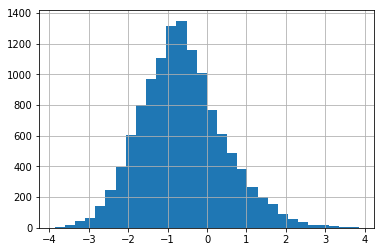

In [27]:
# bias_ratio shows how overrepresented this tract is on craigslist
# add 1 to numerator and denominator to avoid divide by zero and log(0)
tracts['bias_ratio'] = (tracts['clist_count'] + 1) / (tracts['prop_count'] + 1)

# take log(bias) to make it more normally distributed
tracts['bias_log'] = np.log(tracts['bias_ratio'])
tracts['bias_log'].hist(bins=30)

Ratios lack symmetry. When a < b, a/b ranges from 0 to 1. When a > b, a/b ranges from 1 to infinity. Log fixes this. When a = b, a/b = 1 and log(a/b) = 0. Because log(a/b) = -log(b/a), it produces symmetry. This is because log(a/b) = log(a)-log(b), so we are evaluating the algebraic different between (log) values, somewhat similar to bias_diff, but sensibly distributed. 

In [28]:
# done, show results
print(len(tracts))
tracts.head()

12328


,land_area,place_geoid,place_name,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_asian,pct_single_fam_detached,...,pct_burden,median_gross_rent_k,med_income_k,med_home_value_k,pct_white_change_2012_2015,clist_count,prop_count,bias_diff,bias_ratio,bias_log
GEOID,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,0.046,0.171,0.785,0.000,0.705,...,0.604,0.754,24.359,68.4,0.014,3,2.150039,0.849961,1.269826,0.238880
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,0.180,0.046,0.672,0.084,0.326,...,0.534,0.552,20.425,65.3,-0.022,1,2.852092,-1.852092,0.519198,-0.655469
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.007,0.079,0.908,0.000,0.897,...,0.747,0.912,21.759,60.7,0.025,2,2.120786,-0.120786,0.961296,-0.039473
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,0.014,0.050,0.929,0.000,0.546,...,0.547,0.534,21.430,53.7,0.011,0,3.426167,-3.426167,0.225929,-1.487534
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,0.025,0.000,0.977,0.000,0.569,...,0.773,0.505,15.833,52.4,-0.001,0,2.135412,-2.135412,0.318937,-1.142761


In [29]:
sorted(tracts.columns)

['bias_diff',
 'bias_log',
 'bias_ratio',
 'centroid',
 'clist_count',
 'count_renter_occupied_units',
 'county',
 'distance_to_center_km',
 'geometry',
 'land_area',
 'lat_city_center',
 'lng_city_center',
 'mean_travel_time_work',
 'med_home_value_k',
 'med_income_k',
 'med_rooms_in_house',
 'median_age',
 'median_gross_rent_k',
 'pct_20_34',
 'pct_asian',
 'pct_bachelors_or_higher',
 'pct_below_poverty',
 'pct_black',
 'pct_built_before_1940',
 'pct_burden',
 'pct_college_grad_student',
 'pct_commute_drive_alone',
 'pct_english_only',
 'pct_foreign_born',
 'pct_hispanic',
 'pct_nonrelatives_household',
 'pct_renting',
 'pct_same_residence_year_ago',
 'pct_single_fam_detached',
 'pct_white',
 'pct_white_change_2012_2015',
 'place_geoid',
 'place_name',
 'pop_density_k_km',
 'prop_count',
 'rental_vacancy_rate',
 'renter_household_size',
 'renter_occupied_units_km',
 'state',
 'total_pop']

In [30]:
tracts.to_csv(output_path, index=True, encoding='utf-8')
print(output_path)

data/features.csv
